In [1]:
import numpy as np
from matplotlib import colors
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import signac as sg
from scipy.special import gamma
import copy as copy
import scipy
from global_functions import adjustmaps
import h5py
from scipy.interpolate import make_lsq_spline
from itertools import product
import os

# Define/load things non-specific to a given set of results
metric = 'lambda_s'
Aeff = 7.29
t_final = 300
ncell_tot = 87_993
c = 1.42
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
tau_vec = b_vec * gamma(1+1/c)
tauc_methods = ["flat"]
results_pre = 'gte_thresh' 

# Update global plotting parameters
rc('axes', labelsize=21)  # Font size for x and y labels
rc('axes', titlesize=16)
rc('xtick', labelsize=19)  # Font size for x-axis tick labels
rc('ytick', labelsize=19)  # Font size for y-axis tick labels
rc('lines', markersize=15)  
rc('lines', linewidth=5.5)
rc('legend', fontsize=19)
rc('font', family='sans-serif')
rc('font', serif=['Computer Modern Sans Serif'] + plt.rcParams['font.serif'])
rc('font', weight='light')
histlw = 5.5
cbar_lpad = 30
dpi = 50
# dpi = 200

# Function to read in things specific to given results as global variables
def set_globals(results_pre):
    if metric == 'lambda_s':
        #globals()['metric_lab'] = r'$\lambda_{meta}$'
        #globals()['rob_metric_lab'] = r'$\lambda_{meta}^*$'
        #globals()['mean_metric_lab'] = r'$<\lambda>$'
        globals()['metric_lab'] = r'$S$'
        globals()['rob_metric_lab'] = r'$S^*$'
        globals()['mean_metric_lab'] = r'$\bar{\lambda}(\tau)$'
    if metric == 'P_s':
        globals()['metric_lab'] = r'$S_{meta}$'
        globals()['rob_metric_lab'] = r'$\S_{meta}^*$'
        globals()['mean_metric_lab'] = r'$<P_s>$'
    if metric == 's':
        globals()['metric_lab'] = r'$s_{meta}$'
        globals()['rob_metric_lab'] = r'$\s_{meta}^*$'
        globals()['mean_metric_lab'] = r'$<s>$'
    globals()['fn_prefix'] = f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
    #globals()['fig_prefix'] = f"{results_pre}/figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
    globals()['fig_prefix'] = os.path.join('/','Volumes', 'Macintosh HD', 'Users', 'patrick', 
                                           'Google Drive', 'My Drive', 'Research', 'Regan', 'Figs/')

    # Load things saved specific to these results
    globals()['metric_all'] = np.load(f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/metric_all.npy")
    globals()['tau_all'] = np.load(f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/tau_all.npy")
    globals()['C_vec'] = np.load(fn_prefix + "C_vec.npy")
    globals()['C_i_vec'] = np.arange(len(C_vec))[::2]
    globals()['ncell_vec'] = np.load(fn_prefix + "ncell_vec.npy")
    globals()['slice_left_all'] = np.load(fn_prefix + "slice_left_all.npy")
    eps_axes = {}
    with h5py.File(fn_prefix + "eps_axes.h5", "r") as handle:
        for key in handle.keys():
            eps_axes.update({key: handle[key][()]})
    globals()['eps_axes'] = eps_axes

# Read in maps and convert fdm to tau, used by multiple plots below
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt] 
mapindices = np.argwhere(maps_filt)
tau_argsort = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort]

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_44006/695853976.py:95: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


In [2]:
set_globals(results_pre)
x_all = np.load(fn_prefix + '/x_all.npy')
meta_metric_all = np.load(fn_prefix + '/meta_metric_all.npy')
meta_metric_all = meta_metric_all[:,0]

maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

In [3]:
# q_vec = np.arange(0.1, 0.9, 0.1)
q_vec = np.arange(0.05, 0.85, 0.05)

# results = {}
keys = ['delta_range', 'delta_median', 'median', 'range', 'delta_n', 'delta_l', 'n', 'l']
results = {key: np.full((C_vec.size, q_vec.size), np.nan) for key in keys}

for q_i, q in enumerate(q_vec):
    for C_i, C in enumerate(C_vec):
        # First get optimal tau slice stats from optimal decisions under baseline
        zeroeps_filt = np.all(x_all[:, 3:] == 0, axis=1)
        _filt = zeroeps_filt & (x_all[:,0] == C)
        argmax = np.nanargmax(meta_metric_all[_filt])
        S_opt_baseline = meta_metric_all[_filt][argmax]
        n_opt_baseline, sl_opt_baseline = x_all[_filt,:][argmax][1:3].astype(int)
        tau_slice_baseline = tau_sorted[sl_opt_baseline:sl_opt_baseline+n_opt_baseline]
        range_baseline = tau_slice_baseline.max() - tau_slice_baseline.min()
        median_baseline = np.median(tau_slice_baseline)

        # Now get the same statistics for 0.5 * optimal S baseline
        Sstar_rob_i = np.argmin(np.abs( rob_thresh_vec - ((1 - q) * S_opt_baseline)) )
        n_opt_rob = ncell_vec[int(argmaxrob[Sstar_rob_i, C_i][0])]
        sl_opt_rob = slice_left_all[int(argmaxrob[Sstar_rob_i, C_i][1])]
        tau_slice_rob = tau_sorted[sl_opt_rob:sl_opt_rob+n_opt_rob]
        range_rob = tau_slice_rob.max() - tau_slice_rob.min()
        median_rob = np.median(tau_slice_rob)

        results['delta_median'][C_i, q_i] = median_rob - median_baseline
        results['delta_range'][C_i, q_i] = range_rob - range_baseline
        results['median'][C_i, q_i] = median_rob
        results['range'][C_i, q_i] = range_rob
        results['delta_n'][C_i, q_i] = n_opt_rob - n_opt_baseline
        results['delta_l'][C_i, q_i] = sl_opt_rob - sl_opt_baseline
        results['n'][C_i, q_i] = n_opt_rob
        results['l'][C_i, q_i] = sl_opt_rob

In [4]:
results['delta_l+delta_n'] = (results['delta_l'] + results['delta_n']) #/ np.abs(results['delta_n'])

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_44006/1904414451.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(q_vec[q_mask], results[key][C_i, q_mask], marker='o', c=color, alpha=0.8)


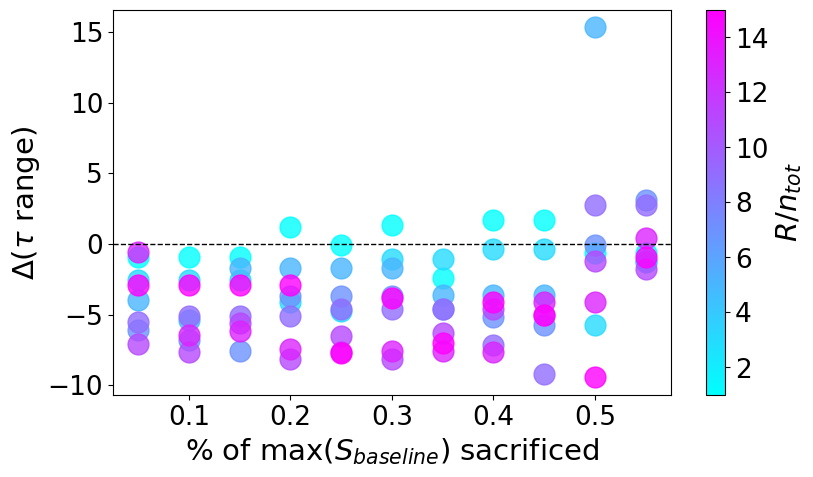

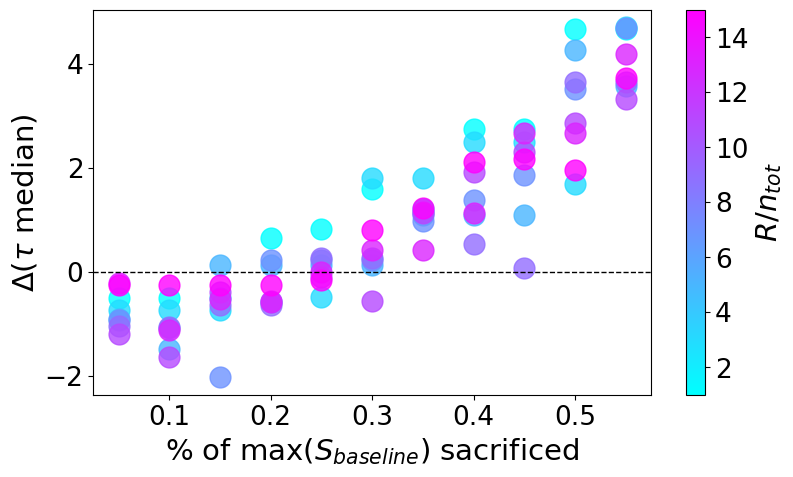

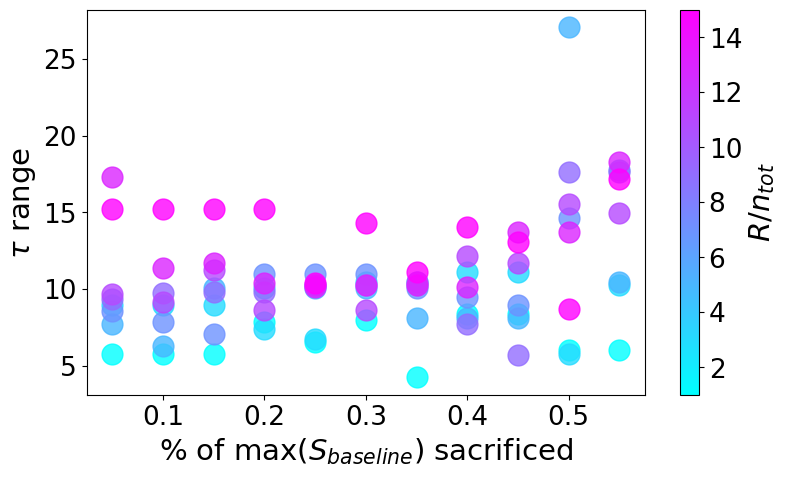

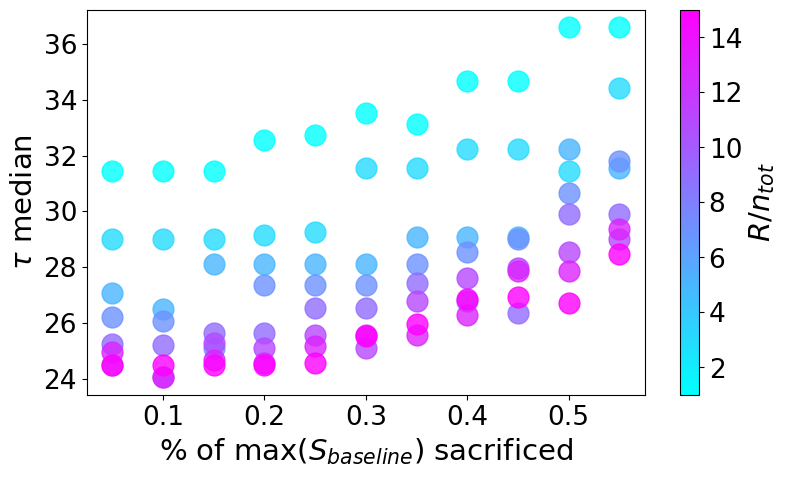

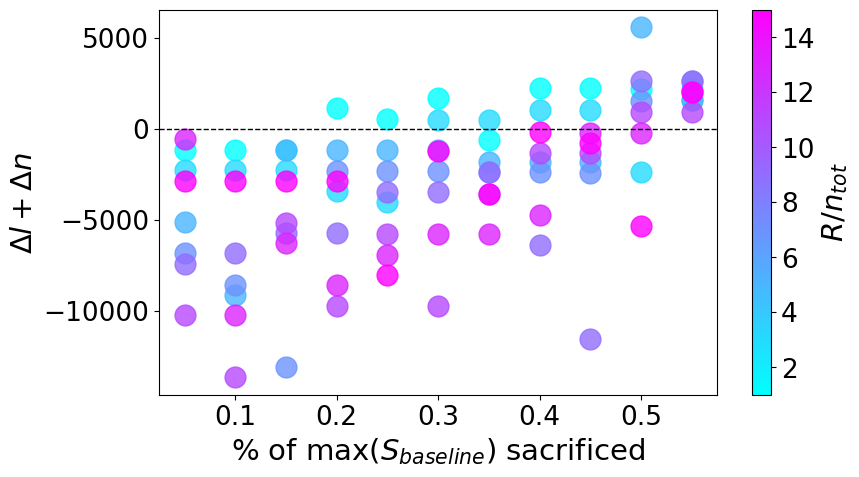

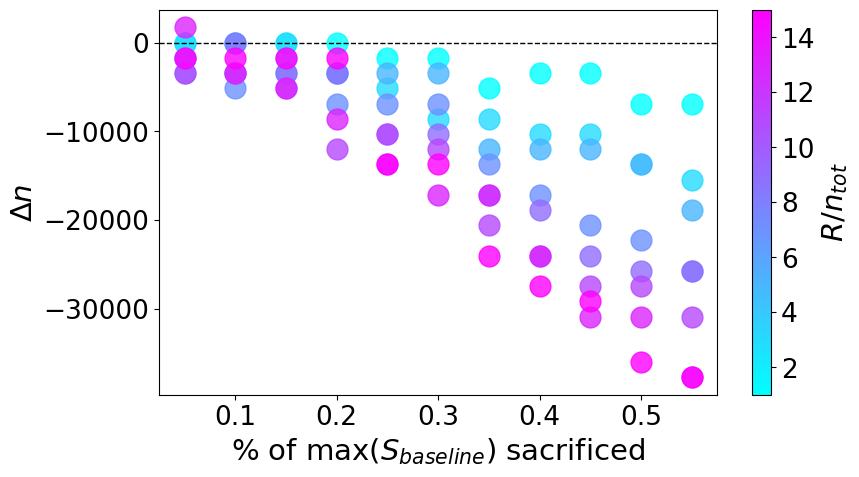

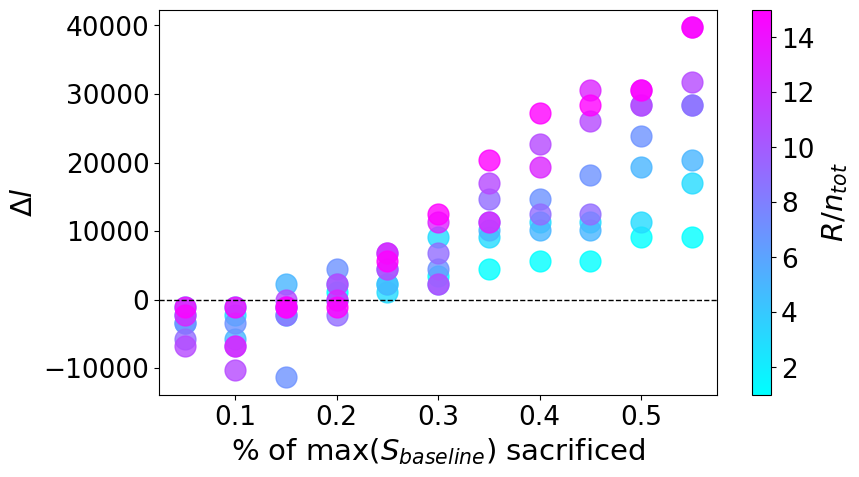

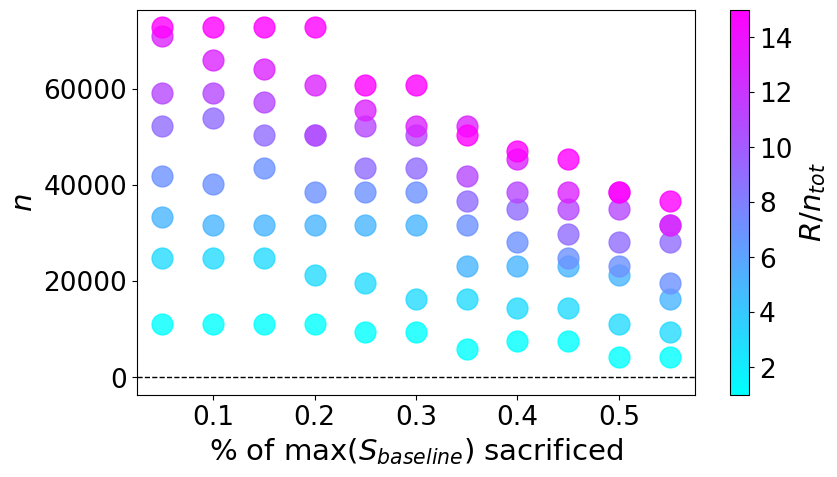

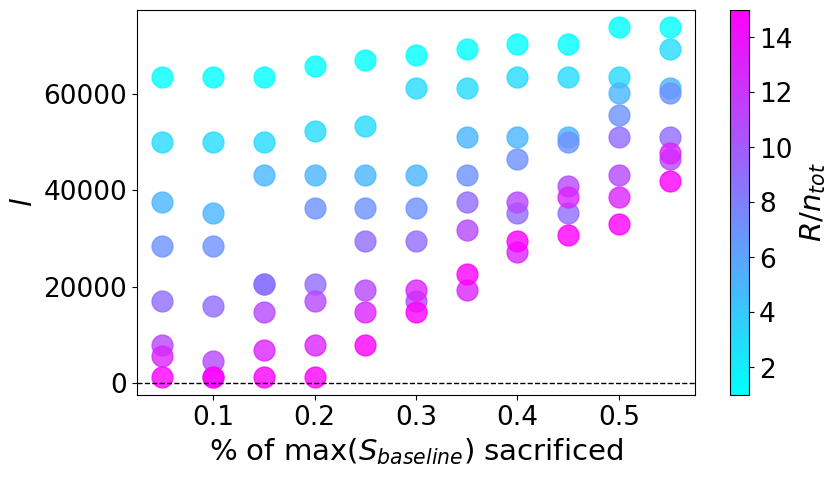

In [5]:
labels = [r'$\Delta(\tau~\text{range})$', r'$\Delta(\tau~\text{median})$', 
          r'$\tau~\text{range}$', r'$\tau~\text{median}$',
          r'$\Delta l + \Delta n$',
          r'$\Delta n$', r'$\Delta l$', r'$n$', r'$l$']
# cmap = copy.copy(cm.RdPu_r)
# cmap = copy.copy(cm.Wistia)
cmap = copy.copy(cm.cool)
norm = colors.Normalize(vmin=C_vec.min()/ncell_tot, vmax=C_vec.max()/ncell_tot)

# Restrict the range of plotting to a desired q value
q_lim = 0.55
q_mask = q_vec <= q_lim 

for key_i, key in enumerate(['delta_range', 'delta_median', 'range', 'median',
                             'delta_l+delta_n', 'delta_n', 'delta_l', 'n', 'l']):
    fig, ax = plt.subplots(figsize=(9,5))
    
    for C_i, C in enumerate(C_vec):
        # if (C_i) % 2 == 0: continue
        # if C_i < 3: continue
        # if C_i > 3: continue
        # if C_i != len(C_vec) - 1: continue
        color = cmap(norm(C/ncell_tot))
        ax.scatter(q_vec[q_mask], results[key][C_i, q_mask], marker='o', c=color, alpha=0.8)
        
    # ax.set_xlabel(r'$q$; $S^*=(1-q)\text{max}(S_{baseline})$')
    ax.set_xlabel(r'% of $\text{max}(S_{baseline})$ sacrificed')
    ax.set_ylabel(labels[key_i])
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(C_vec)
    cbar = fig.colorbar(sm, label=r'$R/n_{tot}$', ax=ax)
    
    if key not in ['range', 'median']:
        ax.axhline(0, ls='--', lw=1, c='k')
    # ax.set_xlim(0.025,0.525)

space

In [ ]:
fractions = np.arange(0.8, 0.2, -0.2)
for fraction in fractions:
    
    delta_median = np.full_like(C_vec, np.nan)
    delta_range = np.full_like(C_vec, np.nan)
    delta_n = np.full_like(C_vec, np.nan)
    delta_sl = np.full_like(C_vec, np.nan)
    
    for C_i, C in enumerate(C_vec):
        # First get optimal tau slice stats from optimal decisions under baseline
        zeroeps_filt = np.all(x_all[:, 3:] == 0, axis=1)
        _filt = zeroeps_filt & (x_all[:,0] == C)
        argmax = np.nanargmax(meta_metric_all[_filt])
        S_opt_baseline = meta_metric_all[_filt][argmax]
        n_opt_baseline, sl_opt_baseline = x_all[_filt,:][argmax][1:3].astype(int)
        tau_slice_baseline = tau_sorted[sl_opt_baseline:sl_opt_baseline+n_opt_baseline]
        range_baseline = tau_slice_baseline.max() - tau_slice_baseline.min()
        median_baseline = np.median(tau_slice_baseline)

        # Now get the same statistics for 0.5 * optimal S baseline
        Sstar_rob_i = np.argmin(np.abs(rob_thresh_vec - (S_opt_baseline * fraction)))
        n_opt_rob = ncell_vec[int(argmaxrob[Sstar_rob_i, C_i][0])]
        sl_opt_rob = slice_left_all[int(argmaxrob[Sstar_rob_i, C_i][1])]
        tau_slice_rob = tau_sorted[sl_opt_rob:sl_opt_rob+n_opt_rob]
        range_rob = tau_slice_rob.max() - tau_slice_rob.min()
        median_rob = np.median(tau_slice_rob)

        delta_median[C_i] = median_rob - median_baseline
        delta_range[C_i] = range_rob - range_baseline
        delta_n[C_i] = n_opt_rob - n_opt_baseline
        delta_sl[C_i] = sl_opt_rob - sl_opt_baseline

    x = C_vec / ncell_tot

    plt.plot(x, delta_range, marker='o', label=r'$\Delta(\tau~\text{range})$')
    plt.plot(x, delta_median, marker='o', label=r'$\Delta(\tau~\text{median})$')
    plt.xlabel('R')
    plt.legend()
    plt.title(f'change at {np.round(fraction, 2)} * baseline S')
    plt.show()

    plt.plot(x, delta_sl + delta_n, marker='o', label=r'$\Delta l + \Delta n$')
    plt.xlabel('R')
    plt.legend()
    plt.title(f'change at {np.round(fraction, 2)} * baseline S')
    plt.show()
    
    plt.plot(x, delta_n, marker='o', label=r'$\Delta n$')
    plt.plot(x, delta_sl, marker='o', label=r'$\Delta l$')
    plt.xlabel('R')
    plt.legend()
    plt.title(f'change at {np.round(fraction, 2)} * baseline S')
    plt.show()